In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

/home/soyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [31]:
experiment_dir = '/data/EFAT/EFAT_output/HC'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['005', '006', '007', 
                '010', '013', '014', '015', 
                '019', '021', '022', '025', 
                '026', '029', '032', '034', 
                '036', '039', '041', 
                '045', '050', 
                '055', '056', '058', '059']

fwhm = [8]

TR = 2.0

In [32]:
def make_input_list(func1, func2):
    input_list = [func1, func2]
    return input_list

make_input1 = Node(Function(input_names = ['func1', 'func2'],
                 output_names = ['input_list_func'],
                 function = make_input_list),
                 name = 'make_input1')

def make_param_list(mc_param1, mc_param2):
    input_list = [mc_param1, mc_param2]
    return input_list

make_input2 = Node(Function(input_names = ['mc_param1', 'mc_param2'],
                 output_names = ['input_list_param'],
                 function = make_param_list),
                 name = 'make_input2')

def make_out_list(outliers1, outliers2):
    input_list = [outliers1, outliers2]
    return input_list

make_input3 = Node(Function(input_names = ['outliers1', 'outliers2'],
                 output_names = ['input_list_out'],
                 function = make_out_list),
                 name = 'make_input3')

In [33]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [34]:
condition_names = ['angry', 'fear', 'happy', 'sad', 'shapes']

cont01 = ['average',        'T', condition_names, [1/5., 1/5., 1/5., 1/5., 1/5]]
cont02 = ['angry',          'T', condition_names, [1, 0, 0, 0, 0]]
cont03 = ['fear',           'T', condition_names, [0, 1, 0, 0, 0]]
cont04 = ['happy',          'T', condition_names, [0, 0, 1, 0, 0]]
cont05 = ['sad',            'T', condition_names, [0, 0, 0, 1, 0]]
cont06 = ['shapes',         'T', condition_names, [0, 0, 0, 0, 1]]
cont07 = ['angry > shapes', 'T', condition_names, [1, 0, 0, 0, -1]]
cont08 = ['fear > shapes',  'T', condition_names, [0, 1, 0, 0, -1]]
cont09 = ['happy > shapes', 'T', condition_names, [0, 0, 1, 0, -1]]
cont10 = ['sad > shapes',   'T', condition_names, [0, 0, 0, 1, -1]]

cont11 = ['activation',     'F', [cont02, cont03, cont04, cont05, cont06]]
cont12 = ['difference',     'F', [cont07, cont08, cont09, cont10]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, 
                 cont07, cont08, cont09, cont10, cont11, cont12]

In [35]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo1 = pd.read_table('/data/EFAT/EFAT_RawData/HC/sub-%s/func/sub-%s_task-EFAT_run-01_events.tsv' % (subject_id,subject_id))
   
    trialinfo1.head()
    conditions1 = []
    onsets1 = []
    durations1 = []
        
    for group in trialinfo1.groupby('trial_type'):
        conditions1.append(group[0])
        onsets1.append(list(group[1].onset - 8)) # subtracting 8s due to removing of 4 dummy scans
        durations1.append(group[1].duration.tolist())
            
    subject_info1 = Bunch(conditions=conditions1,
                            onsets=onsets1,
                            durations=durations1)
                            #amplitudes=None,
                            #tmod=None,
                            #pmod=None,
                            #regressor_names=None,
                            #regressors=None
    
    trialinfo2 = pd.read_table('/data/EFAT/EFAT_RawData/HC/sub-%s/func/sub-%s_task-EFAT_run-02_events.tsv' % (subject_id,subject_id))
    trialinfo2.head()
    conditions2 = []
    onsets2 = []
    durations2 = []
            
    for group in trialinfo2.groupby('trial_type'):
        conditions2.append(group[0])
        onsets2.append(list(group[1].onset - 8))
        durations2.append(group[1].duration.tolist())
                
    subject_info2 = Bunch(conditions=conditions2,
                            onsets=onsets2,
                            durations=durations2)
        
    subject_info = [subject_info1, subject_info2]

    return subject_info # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [36]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func1': opj(output_dir, 'norm_spm', 'sub-{subject_id}_fwhm8',
                         'run-01', 'wfwhm-8_ssub-{subject_id}_task-EFAT_run-01_bold.nii'),
             'func2': opj(output_dir, 'norm_spm', 'sub-{subject_id}_fwhm8',
                         'run-02', 'wfwhm-8_ssub-{subject_id}_task-EFAT_run-02_bold.nii'),
             'mc_param1': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-EFAT',
                             'run-01', 'sub-{subject_id}_task-EFAT_run-01_bold.par'),
             'mc_param2': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-EFAT',
                             'run-02', 'sub-{subject_id}_task-EFAT_run-02_bold.par'),
             'outliers1': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-EFAT', 
                             'run-01', 'art.sub-{subject_id}_task-EFAT_run-01_bold_outliers.txt'),
             'outliers2': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-EFAT', 
                             'run-02', 'art.sub-{subject_id}_task-EFAT_run-02_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'EFAT'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [37]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id'),]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    
                    (selectfiles, make_input1, [('func1', 'func1')]),
                    (selectfiles, make_input1, [('func2', 'func2')]),
                    (make_input1, modelspec, [('input_list_func', 'functional_runs')]),
                    
                    (selectfiles, make_input2, [('mc_param1', 'mc_param1')]),
                    (selectfiles, make_input2, [('mc_param2', 'mc_param2')]),
                    (make_input2, modelspec, [('input_list_param', 'realignment_parameters')]),
                    
                    (selectfiles, make_input3, [('outliers1', 'outliers1')]),
                    (selectfiles, make_input3, [('outliers2', 'outliers2')]),
                    (make_input3, modelspec, [('input_list_out', 'outlier_files')]),
                                   
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image'),
                                                   ]),
                    (level1estimate, datasink, [('mask_image', '1stLevel.@mask')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

190124-16:03:42,819 nipype.workflow INFO:
	 Generated workflow graph: /data/EFAT/EFAT_output/HC/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


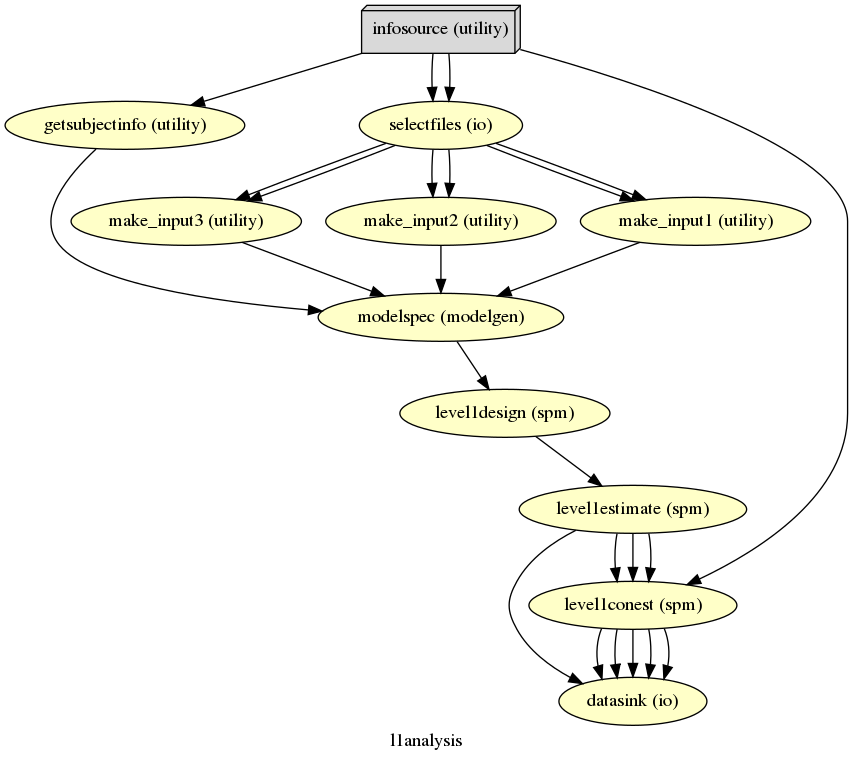

In [38]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

In [39]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 7})

190124-16:03:42,911 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
190124-16:03:43,190 nipype.workflow INFO:
	 Running in parallel.
190124-16:03:43,202 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 50 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 7/7.
190124-16:03:43,329 nipype.workflow INFO:
	 [Job 0] Cached (l1analysis.getsubjectinfo).
190124-16:03:43,396 nipype.workflow INFO:
	 [Job 10] Cached (l1analysis.getsubjectinfo).
190124-16:03:43,397 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/data/EFAT/EFAT_output/HC/workingdir/l1analysis/_fwhm_id_8_subject_id_059/selectfiles".
190124-16:03:43,404 nipype.workflow INFO:
	 [Job 20] Cached (l1analysis.getsubjectinfo).
190124-16:03:43,406 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/data/EFAT/EFAT_output/HC/workingdir/l1analysis/_fwhm_id_8_subject_id_058/selectfiles".190124-16:03:43,410 nipype.workflow INFO:
	

In [43]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [52]:
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-005/fwhm-8/SPM.mat',
                 struct_as_record=False)

In [53]:
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

In [54]:
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

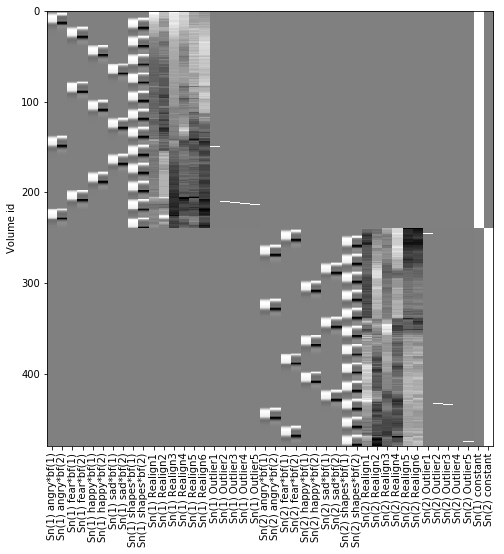

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

In [72]:
from nilearn.plotting import plot_stat_map
anatimg = '/home/soyeon/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'
# anatimg = '/opt/spm12/tpm/TPM.nii'

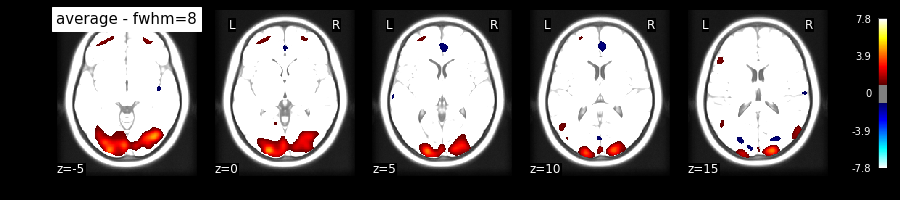

In [74]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-013/fwhm-8/con_0007.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=1, display_mode='z', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

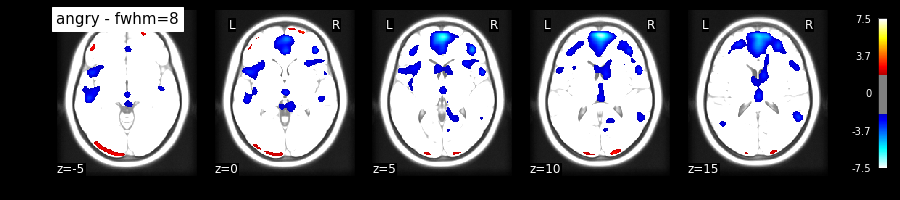

In [67]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-007/fwhm-8/con_0002.nii', title='angry - fwhm=8',
    bg_img=anatimg, threshold=2, display_mode='z', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

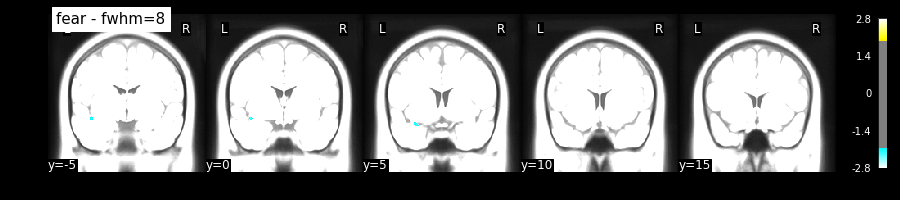

In [26]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0003.nii', title='fear - fwhm=8',
    bg_img=anatimg, threshold=2, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

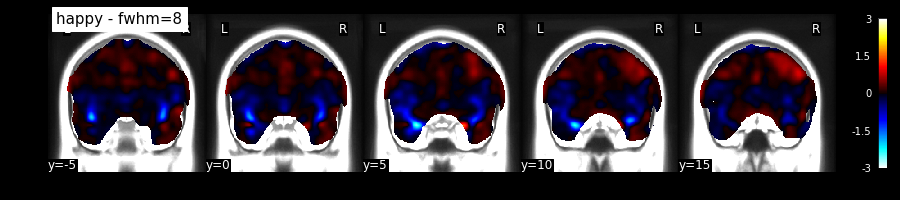

In [39]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0004.nii', title='happy - fwhm=8',
    bg_img=anatimg, threshold=1e-06, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

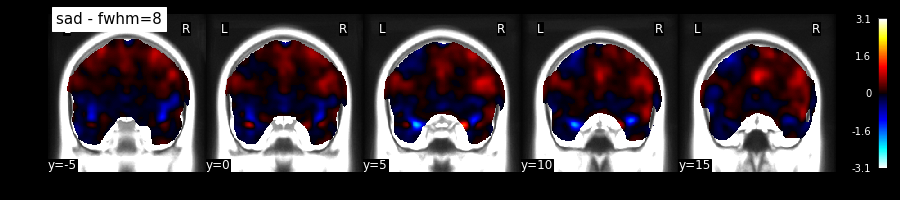

In [40]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0005.nii', title='sad - fwhm=8',
    bg_img=anatimg, threshold=1e-06, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

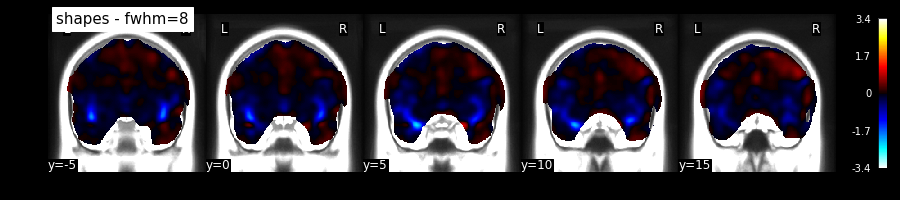

In [41]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0006.nii', title='shapes - fwhm=8',
    bg_img=anatimg, threshold=1e-06, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

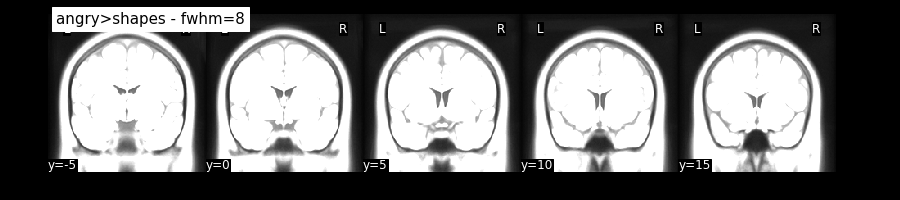

In [13]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0007.nii', title='angry>shapes - fwhm=8',
    bg_img=anatimg, threshold=1, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

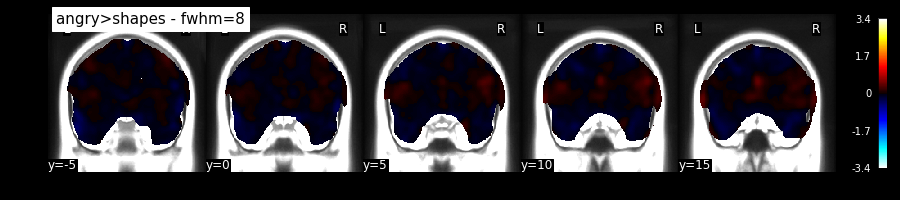

In [44]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0008.nii', title='angry>shapes - fwhm=8',
    bg_img=anatimg, threshold=1e-06, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

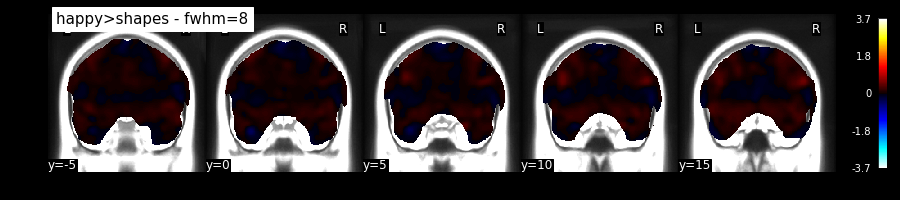

In [46]:
plot_stat_map(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0009.nii', title='happy>shapes - fwhm=8',
    bg_img=anatimg, threshold=1e-06, display_mode='y', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

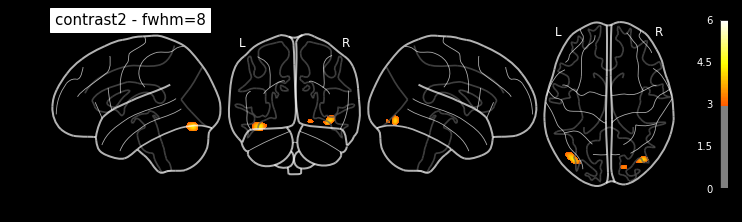

In [18]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-059/fwhm-8/con_0007.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast2 - fwhm=8')